In [1]:
import pandas as pd
import numpy as np
import nltk
import itertools
import matplotlib.pyplot as plt

In [2]:
import winsound
import time

In [3]:
def beep(reps=1, duration=500, freq=440, sleep=1):
    for _ in range(reps - 1):
        winsound.Beep(freq, duration)
        time.sleep(sleep)
    winsound.Beep(freq, duration)

In [4]:
# data = "amazon_reviews/dataset/Video_Games_5.json.gz"
data = "dataset/Cell_Phones_and_Accessories_5.json.gz"
df = pd.read_json(data, lines = True, compression = "gzip")
df.head()

,asin,image,overall,reviewText,reviewTime,reviewerID,reviewerName,style,summary,unixReviewTime,verified,vote
0,7508492919,NaN,5,Looks even better in person. Be careful to not...,"08 4, 2014",A24E3SXTC62LJI,Claudia Valdivia,{'Color:': ' Bling'},Can't stop won't stop looking at it,1407110400,True,NaN
1,7508492919,NaN,5,When you don't want to spend a whole lot of ca...,"02 12, 2014",A269FLZCB4GIPV,sarah ponce,NaN,1,1392163200,True,NaN
2,7508492919,NaN,3,"so the case came on time, i love the design. I...","02 8, 2014",AB6CHQWHZW4TV,Kai,NaN,Its okay,1391817600,True,NaN
3,7508492919,NaN,2,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,"02 4, 2014",A1M117A53LEI8,Sharon Williams,NaN,CASE,1391472000,True,NaN
4,7508492919,NaN,4,"I liked it because it was cute, but the studs ...","02 3, 2014",A272DUT8M88ZS8,Bella Rodriguez,NaN,Cute!,1391385600,True,NaN


There are some missing values:

In [5]:
df["reviewText"].isnull().any()

True

In [6]:
X = df.reviewText[df.reviewText.notnull()].values
y = df.overall[df.reviewText.notnull()].values

In [8]:
classes = np.unique(y)
for c in classes:
    print("{}: {:.5f}".format(c, np.sum(y==c)/len(y)))

1: 0.07228
2: 0.05069
3: 0.08709
4: 0.16348
5: 0.62645


In [9]:
def int2sent(n):
    if n >= 4:
        return "positive"
    if n <= 3:
        return "negative"

In [10]:
vectInt2sent = np.vectorize(int2sent)
ysent = vectInt2sent(y)
for c in np.unique(ysent):
    print("{:10s} {}".format(c, np.sum(ysent==c)/len(ysent)))

negative   0.2100664022871899
positive   0.7899335977128101


In [11]:
# Positive Class: ranking 4 or 5
yp = y > 3

In [12]:
for c in np.unique(yp):
    print("{}: {:.5f}".format(c, np.sum(yp==c)/len(yp)))

False: 0.21007
True: 0.78993


## Preprocessing (Stemmer, Vectorizer, Train-Test Split)

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#### Train-test split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, yp, test_size=0.33, random_state=42)

#### Define class for Count/TfIdf vectorizer + stemming 

In [15]:
# pystemmer, faster than nltk
import Stemmer

In [16]:
english_stemmer = Stemmer.Stemmer('en')

In [17]:
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(CountVectorizer, self).build_analyzer()
        return lambda doc: english_stemmer.stemWords(analyzer(doc))

In [18]:
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: english_stemmer.stemWords(analyzer(doc))

#### Stemming + Count/TfIdf Representation

In [ ]:
# count_vectorizer_stemmed = StemmedCountVectorizer(min_df=1, analyzer='word', ngram_range=(1,1))
# count_vectorizer_stemmed.fit(X_train)
# beep()

In [ ]:
# tfidf_vectorizer_stemmed = StemmedTfidfVectorizer(min_df=1, analyzer='word', ngram_range=(1,1))
# tfidf_vectorizer_stemmed.fit(X_train)
# beep()

In [19]:
from joblib import dump, load

In [ ]:
# dump(count_vectorizer_stemmed, 'count_vectorizer_stemmed.joblib')

In [ ]:
# dump(tfidf_vectorizer_stemmed, 'tfidf_vectorizer_stemmed.joblib')

Load fitted vectorizers:

In [20]:
cvs = load('count_vectorizer_stemmed.joblib')
tvs = load('tfidf_vectorizer_stemmed.joblib')

In [ ]:
# X_train_count = cvs.transform(X_train)
# X_test_count = cvs.transform(X_test)
# beep()

In [ ]:
# X_train_tfidf = tvs.transform(X_train)
# X_test_tfidf = tvs.transform(X_test)
# beep()

In [ ]:
# dump(X_train_count, 'X_train_count.joblib')
# dump(X_test_count,  'X_test_count.joblib')
# dump(X_train_tfidf, 'X_train_tfidf.joblib')
# dump(X_test_tfidf,  'X_test_tfidf.joblib')

In [21]:
X_train_count = load('X_train_count.joblib')
X_test_count = load('X_test_count.joblib')
X_train_tfidf = load('X_train_tfidf.joblib')
X_test_tfidf = load('X_test_tfidf.joblib')

## NB Classifier

In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, f1_score, fbeta_score, precision_score, recall_score

Function for printing most discriminative features for positive class:

In [23]:
def print_top(feature_names, clf, n = 10):
    top_pos = np.argsort(clf.coef_[0])[-n:]
    top_pos = top_pos[::-1]
    print("Most discriminative features:\n",
          ", ".join(feature_names[j] for j in top_pos))

### Count Representation

In [24]:
clf = MultinomialNB()

In [25]:
clf.fit(X_train_count, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [26]:
fnames = cvs.get_feature_names()
print_top(fnames, clf, 20)

Most discriminative features:
 the, it, and, to, is, this, my, for, phone, case, of, that, in, on, with, you, have, but, great, not


There are many stopwords.

In [27]:
train_score = clf.score(X_train_count, y_train) # Train Accuracy
test_score = clf.score(X_test_count, y_test)    # Test Accuracy

In [28]:
predictions = clf.predict(X_test_count)

In [29]:
prec = precision_score(y_test, predictions) # Precision
rec = recall_score(y_test, predictions) # Recall
f1 = f1_score(y_test, predictions) # F1
f2 = fbeta_score(y_test, predictions, 2) # F2
cm = confusion_matrix(y_test, predictions)

In [30]:
cm # confusion matrix

array([[ 47562,  30662],
       [ 22267, 271641]], dtype=int64)

In [31]:
proba = clf.predict_proba(X_test_count)

In [32]:
precision, recall, pr_thresholds = precision_recall_curve(y_test, proba[:,1])

In [33]:
auc_score = auc(recall, precision)

In [34]:
scores_strings = ["Train Accuracy", "Test Accuracy", "Test Precision",
                  "Test Recall", "F1", "F2", "P/R AUC"]

In [35]:
scores = [train_score, test_score, prec, rec, f1, f2, auc_score]

In [36]:
print(("{:20s} {:.5f}\n"*7)[:-1].format(*itertools.chain(*zip(scores_strings, scores))))

Train Accuracy       0.86323
Test Accuracy        0.85777
Test Precision       0.89857
Test Recall          0.92424
F1                   0.91122
F2                   0.91899
P/R AUC              0.95750


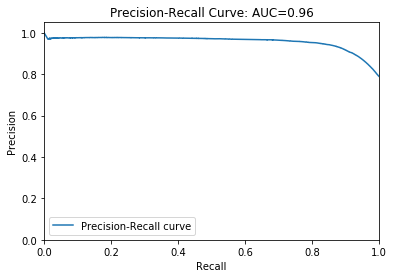

In [37]:
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AUC=%0.2f' % auc_score)
plt.legend(loc="lower left")
plt.show()

### TfIdf Representation

In [38]:
clf = MultinomialNB()

In [39]:
clf.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [40]:
fnames = tvs.get_feature_names()
print_top(fnames, clf, 20)

Most discriminative features:
 the, it, and, great, good, to, case, my, this, is, phone, love, for, work, veri, product, of, perfect, on, fit


Again, many stopwords

In [41]:
train_score = clf.score(X_train_tfidf, y_train) # Train Accuracy
test_score = clf.score(X_test_tfidf, y_test)    # Test Accuracy

In [42]:
predictions = clf.predict(X_test_tfidf)

In [43]:
prec = precision_score(y_test, predictions) # Precision
rec = recall_score(y_test, predictions) # Recall
f1 = f1_score(y_test, predictions) # F1
f2 = fbeta_score(y_test, predictions, 2) # F2
cm = confusion_matrix(y_test, predictions)

In [44]:
cm

array([[ 16047,  62177],
       [  1609, 292299]], dtype=int64)

In [45]:
proba = clf.predict_proba(X_test_tfidf)

In [46]:
precision, recall, pr_thresholds = precision_recall_curve(y_test, proba[:,1])

In [47]:
auc_score = auc(recall, precision)

In [48]:
scores_strings = ["Train Accuracy", "Test Accuracy", "Test Precision",
                  "Test Recall", "F1", "F2", "P/R AUC"]

In [49]:
scores = [train_score, test_score, prec, rec, f1, f2, auc_score]

In [50]:
print(("{:20s} {:.5f}\n"*7)[:-1].format(*itertools.chain(*zip(scores_strings, scores))))

Train Accuracy       0.83265
Test Accuracy        0.82859
Test Precision       0.82459
Test Recall          0.99453
F1                   0.90162
F2                   0.95516
P/R AUC              0.96984


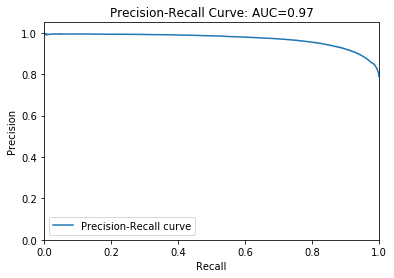

In [51]:
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AUC=%0.2f' % auc_score)
plt.legend(loc="lower left")
plt.show()

## Bigrams

In [ ]:
# bigram_vectorizer_stemmed = StemmedTfidfVectorizer(min_df=1, analyzer='word', ngram_range=(1,2))

In [ ]:
# bigram_vectorizer_stemmed.fit(X_train)

In [ ]:
# beep()

In [ ]:
# dump(bigram_vectorizer_stemmed, 'bigram_vectorizer_stemmed.joblib')

In [52]:
bvs = load('bigram_vectorizer_stemmed.joblib')

In [ ]:
# beep()

In [ ]:
# X_train_bigram = bvs.transform(X_train)
# X_test_bigram = bvs.transform(X_test)
# beep()

In [ ]:
# dump(X_train_bigram, 'X_train_bigram.joblib')
# dump(X_test_bigram,  'X_test_bigram.joblib')

In [53]:
X_train_bigram = load('X_train_bigram.joblib')
X_test_bigram = load('X_test_bigram.joblib')

In [54]:
# beep()

### NB with Bigram Representation

In [55]:
clf = MultinomialNB()

In [56]:
clf.fit(X_train_bigram, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [57]:
fnames = bvs.get_feature_names()

In [58]:
print_top(fnames, clf, 20)

Most discriminative features:
 the, it, great, good, and, to, case, my, this, is, love, work, phone, for, veri, excel, product, perfect, nice, of


In [59]:
train_score = clf.score(X_train_bigram, y_train) # Train Accuracy
test_score = clf.score(X_test_bigram, y_test)    # Test Accuracy

In [60]:
predictions = clf.predict(X_test_bigram)

In [61]:
prec = precision_score(y_test, predictions) # Precision
rec = recall_score(y_test, predictions) # Recall
f1 = f1_score(y_test, predictions) # F1
f2 = fbeta_score(y_test, predictions, 2) # F2
cm = confusion_matrix(y_test, predictions)

In [62]:
proba = clf.predict_proba(X_test_bigram)

In [63]:
precision, recall, pr_thresholds = precision_recall_curve(y_test, proba[:,1])

In [64]:
auc_score = auc(recall, precision)

In [65]:
scores_strings = ["Train Accuracy", "Test Accuracy", "Test Precision",
                  "Test Recall", "F1", "F2", "P/R AUC"]

In [66]:
scores = [train_score, test_score, prec, rec, f1, f2, auc_score]

In [67]:
print(("{:20s} {:.5f}\n"*7)[:-1].format(*itertools.chain(*zip(scores_strings, scores))))

Train Accuracy       0.81460
Test Accuracy        0.80796
Test Precision       0.80483
Test Recall          0.99914
F1                   0.89152
F2                   0.95311
P/R AUC              0.94812


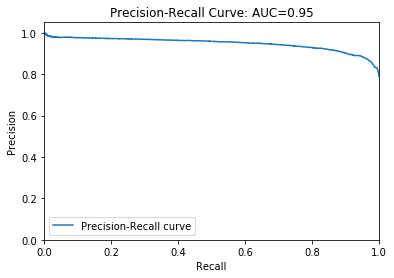

In [68]:
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AUC=%0.2f' % auc_score)
plt.legend(loc="lower left")
plt.show()

In [69]:
# fpidx = (predictions == 1) & (y_test == 0) # index for false positive reviews

In [ ]:
# sum(fpidx)

In [ ]:
# X_test[fpidx][0]

## Stop words removal

In [70]:
from nltk.corpus import stopwords

In [71]:
stopws = stopwords.words("english")

We might want to keep the following words:

In [72]:
np.array(stopws[-36:])

array(['ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
       'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven',
       "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
       "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn',
       "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't",
       'wouldn', "wouldn't"], dtype='<U9')

In [73]:
len(stopws)

179

In [74]:
stopws = stopws[:-36]

In [75]:
len(stopws)

143

Other words that we might not want to remove:

In [76]:
words2save = ["but", "while", "against", "not", "only", "very", 'don', "don't"]

In [77]:
for w in words2save:
    stopws.remove(w)

In [78]:
len(stopws)

135

### TfIdf/Unigrams/Stemming/Stopwords Removal

In [ ]:
# sw_tfidf_vectorizer_stemmed = StemmedTfidfVectorizer(min_df=1, analyzer='word', ngram_range=(1,1), stop_words = stopws)
# sw_tfidf_vectorizer_stemmed.fit(X_train)
# beep()

In [ ]:
# dump(sw_tfidf_vectorizer_stemmed, 'sw_tfidf_vectorizer_stemmed.joblib')

In [79]:
swtvs = load('sw_tfidf_vectorizer_stemmed.joblib')

In [ ]:
# X_train_sw = swtvs.transform(X_train)
# X_test_sw = swtvs.transform(X_test)
# beep()

In [ ]:
# dump(X_train_sw, 'X_train_sw.joblib')
# dump(X_test_sw,  'X_test_sw.joblib')

In [80]:
X_train_sw = load('X_train_sw.joblib')
X_test_sw = load('X_test_sw.joblib')

### NB

In [81]:
clf = MultinomialNB()

In [82]:
clf.fit(X_train_sw, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [83]:
fnames = swtvs.get_feature_names()
print_top(fnames, clf, 20)

Most discriminative features:
 great, good, case, phone, love, work, veri, product, perfect, fit, nice, but, like, protect, well, excel, use, screen, one, charg


In [84]:
train_score = clf.score(X_train_sw, y_train) # Train Accuracy
test_score = clf.score(X_test_sw, y_test)    # Test Accuracy

In [85]:
predictions = clf.predict(X_test_sw)

In [86]:
prec = precision_score(y_test, predictions) # Precision
rec = recall_score(y_test, predictions) # Recall
f1 = f1_score(y_test, predictions) # F1
f2 = fbeta_score(y_test, predictions, 2) # F2
cm = confusion_matrix(y_test, predictions)

In [87]:
cm

array([[ 17515,  60709],
       [  1986, 291922]], dtype=int64)

In [88]:
proba = clf.predict_proba(X_test_sw)

In [89]:
precision, recall, pr_thresholds = precision_recall_curve(y_test, proba[:,1])

In [90]:
auc_score = auc(recall, precision)

In [91]:
scores_strings = ["Train Accuracy", "Test Accuracy", "Test Precision",
                  "Test Recall", "F1", "F2", "P/R AUC"]

In [92]:
scores = [train_score, test_score, prec, rec, f1, f2, auc_score]

In [93]:
print(("{:20s} {:.5f}\n"*7)[:-1].format(*itertools.chain(*zip(scores_strings, scores))))

Train Accuracy       0.83629
Test Accuracy        0.83152
Test Precision       0.82784
Test Recall          0.99324
F1                   0.90303
F2                   0.95508
P/R AUC              0.96935


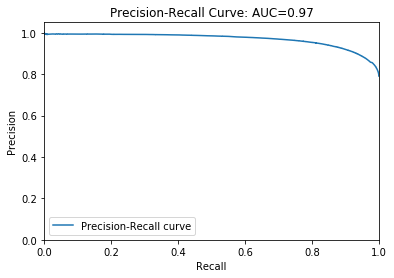

In [94]:
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AUC=%0.2f' % auc_score)
plt.legend(loc="lower left")
plt.show()

### TfIdf/Bigrams/Stemming/Stopwords Removal

In [95]:
# Bswtvs = StemmedTfidfVectorizer(min_df=1, analyzer='word', ngram_range=(1,2), stop_words = stopws)
# Bswtvs.fit(X_train)
# beep()

In [96]:
# dump(Bswtvs, 'Bsw_tfidf_vectorizer_stemmed.joblib')

In [97]:
Bswtvs = load('Bsw_tfidf_vectorizer_stemmed.joblib')

In [ ]:
# X_train_Bsw = Bswtvs.transform(X_train)
# X_test_Bsw = Bswtvs.transform(X_test)
# beep()

In [ ]:
# dump(X_train_Bsw, 'X_train_Bsw.joblib')
# dump(X_test_Bsw,  'X_test_Bsw.joblib')

In [98]:
X_train_Bsw = load('X_train_Bsw.joblib')
X_test_Bsw = load('X_test_Bsw.joblib')

### NB

In [99]:
clf = MultinomialNB()

In [100]:
clf.fit(X_train_Bsw, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [101]:
fnames = Bswtvs.get_feature_names()

In [102]:
print_top(fnames, clf, 50)

Most discriminative features:
 great, good, love, case, phone, work, veri, product, excel, perfect, nice, fit, like, but, well, protect, use, screen, charg, one, not, works great, look, price, great product, thank, easi, qualiti, very good, protector, time, realli, would, iphon, recommend, get, ok, awesom, charger, screen protector, need, buy, expect, great cas, batteri, color, good product, fast, feel, bought


In [103]:
train_score = clf.score(X_train_Bsw, y_train) # Train Accuracy
test_score = clf.score(X_test_Bsw, y_test)    # Test Accuracy

In [104]:
predictions = clf.predict(X_test_Bsw)

In [105]:
prec = precision_score(y_test, predictions) # Precision
rec = recall_score(y_test, predictions) # Recall
f1 = f1_score(y_test, predictions) # F1
f2 = fbeta_score(y_test, predictions, 2) # F2
cm = confusion_matrix(y_test, predictions)

In [106]:
cm

array([[  6038,  72186],
       [   171, 293737]], dtype=int64)

In [107]:
proba = clf.predict_proba(X_test_Bsw)

In [108]:
precision, recall, pr_thresholds = precision_recall_curve(y_test, proba[:,1])

In [109]:
auc_score = auc(recall, precision)

In [110]:
scores_strings = ["Train Accuracy", "Test Accuracy", "Test Precision",
                  "Test Recall", "F1", "F2", "P/R AUC"]

In [111]:
scores = [train_score, test_score, prec, rec, f1, f2, auc_score]

In [112]:
print(("{:20s} {:.5f}\n"*7)[:-1].format(*itertools.chain(*zip(scores_strings, scores))))

Train Accuracy       0.81373
Test Accuracy        0.80556
Test Precision       0.80273
Test Recall          0.99942
F1                   0.89034
F2                   0.95273
P/R AUC              0.95254


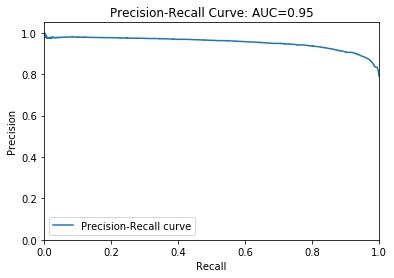

In [113]:
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AUC=%0.2f' % auc_score)
plt.legend(loc="lower left")
plt.show()